In [17]:
from firedrake import *
from tqdm.auto import tqdm, trange
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## generate tensor field

input

In [49]:
def forward_model(E, nu, strain_tensor):
    # Mesh refinement parameters
    nx, ny = 20, 20
    mesh = RectangleMesh(nx, ny, 1, 1)
    x, y = SpatialCoordinate(mesh)
    V = VectorFunctionSpace(mesh, 'CG', 1)
    # Test and trial function for the displacement field
    v, u_ = TestFunction(V), TrialFunction(V)
    u = Function(V, name="Displacement")

    # Lamé parameter
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # Constitutive equations
    def eps(v):
        return 0.5*(grad(v) + grad(v).T)
    def sigma(v):
        d = 2
        return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
    # Body force
    f = Constant((0.0, 0.0))
    # Facet normal vector in each boundary
    n = FacetNormal(mesh)
    
    # Convert strain tensor into displacement boundary conditions
    exx, eyy, exy = strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]
    uLx = - exx/2 + exy * (y-.5)
    uLy = eyy * (y-.5) - exy/2
    uRx = exx/2 + exy * (y-.5)
    uRy = eyy * (y-.5) + exy/2
    
    uBx = exx * (x-.5) - exy/2
    uBy = - eyy/2 + exy * (x-.5)
    uTx = exx * (x-.5) + exy/2
    uTy = eyy/2 + exy * (x-.5)

    # Boundary conditions
    bcL = DirichletBC(V, [uLx, uLy], 1)
    bcR = DirichletBC(V, [uRx, uRy], 2)
    bcB = DirichletBC(V, [uBx, uBy], 3)
    bcT = DirichletBC(V, [uTx, uTy], 4)

    # Formal equation is div(sigma(u)) = f
    # Form
    a = inner(sigma(u_), eps(v)) * dx    
    L = inner(f, v) * dx
    # Solve PDE
    solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

    # Get the coordinates of the mesh nodes
    coords = mesh.coordinates.dat.data

    # Boundary stress
    sxx = assemble(.5*sigma(u)[0, 0] * ds(1) + .5*sigma(u)[0, 0] * ds(2))
    syy = assemble(.5*sigma(u)[1, 1] * ds(3) + .5*sigma(u)[1, 1] * ds(4))
    sxy_syx = assemble(.25*sigma(u)[0, 1] * ds(1) +
                       .25*sigma(u)[0, 1] * ds(2) +
                       .25*sigma(u)[1, 0] * ds(3) +
                       .25*sigma(u)[1, 0] * ds(4))
    # Enforce symmetry: Sxy = Syx

    stress_tensor = np.array([[sxx, sxy_syx],
                              [sxy_syx, syy]])
    
    displaced_coordinates = interpolate(SpatialCoordinate(mesh) + u, V)
    displaced_mesh = Mesh(displaced_coordinates)


    return stress_tensor


In [120]:
def get_dataset(ntrain, ntest, E, nu):
    X, y = [], []
    for _ in tqdm(range(ntrain + ntest)):
        # Generate diagonal elements
        a11, a12, a22 = [np.random.uniform(-0.2, 0.2) for _ in range(3)]
        # Construct the 2x2 matrix
        strain = np.array([[a11, a12], [a12, a22]])
        # epsilon.interpolate(as_tensor(strain))
        stress = forward_model(E, nu, strain)
        # print(stress.shape)
        X.append(strain)
        y.append(stress)
    X_train, X_test = X[:ntrain], X[ntrain:]
    y_train, y_test = y[:ntrain], y[ntrain:]
    np.save("data/datasets/linear_elasticity/train.npy", (X_train, y_train))
    np.save("data/datasets/linear_elasticity/test.npy", (X_test, y_test))

In [121]:
ntrain = 200
ntest = 20
E = Constant(210e9)  # Young's modulus in Pa
nu = Constant(0.3)  # Poisson's ratio
get_dataset(ntrain, ntest, E, nu)

100%|██████████| 220/220 [13:46<00:00,  3.75s/it]

[array([[ 0.09410433, -0.1084551 ],
       [-0.1084551 ,  0.14144617]]), array([[-0.12576228,  0.09502001],
       [ 0.09502001, -0.0791494 ]]), array([[ 0.13591177, -0.19617329],
       [-0.19617329,  0.14723343]]), array([[-0.12625691, -0.13690438],
       [-0.13690438,  0.02787631]]), array([[-0.05462727, -0.19843069],
       [-0.19843069,  0.00976255]]), array([[ 0.06245012, -0.07764597],
       [-0.07764597, -0.09498354]]), array([[ 0.05986678, -0.09732724],
       [-0.09732724, -0.16460061]]), array([[-0.11327652, -0.08826849],
       [-0.08826849,  0.06543918]]), array([[0.00370002, 0.12139347],
       [0.12139347, 0.12396461]]), array([[-0.03252492, -0.03476143],
       [-0.03476143, -0.03023149]]), array([[-0.14672281,  0.11335137],
       [ 0.11335137, -0.19577661]]), array([[-0.00085439,  0.0199382 ],
       [ 0.0199382 , -0.19331763]]), array([[ 0.18544938, -0.04747924],
       [-0.04747924,  0.14050403]]), array([[-0.10210173,  0.02275968],
       [ 0.02275968, -0.08680412

In [122]:
X_test,y_test = np.load("data/datasets/linear_elasticity/test.npy")
X_train, y_train = np.load("data/datasets/linear_elasticity/train.npy")

# Min-Max Normalization
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

X_train_norm = min_max_normalize(X_train)
y_train_norm = min_max_normalize(y_train)
X_test_norm = min_max_normalize(X_test)
y_test_norm = min_max_normalize(y_test)

# Standardization
# Z-score Normalization (Standardization)
def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

X_train_norm = standardize(X_train)
y_train_norm = standardize(y_train)
X_test_norm = standardize(X_test)
y_test_norm = standardize(y_test)

# print("X_train",X_train_norm)
# print("y_train",y_train_norm)


# X_train_norm, y_train_norm = normalize_data(X_train, y_train)
# X_test_norm, y_test_norm = normalize_data(X_test, y_test)



In [123]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler

# Define your machine learning model
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        # Define your model architecture
        self.fc1 = nn.Linear(3, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 32)
        self.fc4 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
def extract_upper_triangle(matrix):
    indices = np.triu_indices(matrix.shape[1])
    return matrix[:, indices[0], indices[1]]

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ... [Your MLP_model class definition here]

# Extract the upper triangle of the matrix
def extract_upper_triangle(matrix):
    indices = np.triu_indices(matrix.shape[1])
    return matrix[:, indices[0], indices[1]]

# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=2000, lr=0.00025):
    # Convert data to PyTorch tensors and extract upper triangle
    X_train_tensor = torch.tensor(extract_upper_triangle(X_train), dtype=torch.float32)
    y_train_tensor = torch.tensor(extract_upper_triangle(y_train), dtype=torch.float32)
    X_test_tensor = torch.tensor(extract_upper_triangle(X_test), dtype=torch.float32)
    y_test_tensor = torch.tensor(extract_upper_triangle(y_test), dtype=torch.float32)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    test_losses = []
    # Training loop
    for epoch in range(epochs):
        # Forward pass
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        losses.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        # Print loss every 10 epochs
        # if (epoch+1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    # Print final loss
    print(f'Final loss: {loss.item():.4f}')
    print(f'Final test loss: {test_loss.item():.4f}')
    plt.plot(test_losses)
    plt.plot(losses)
    # Evaluate the model on the test set
    



Final loss: 0.0070
Final test loss: 0.0150


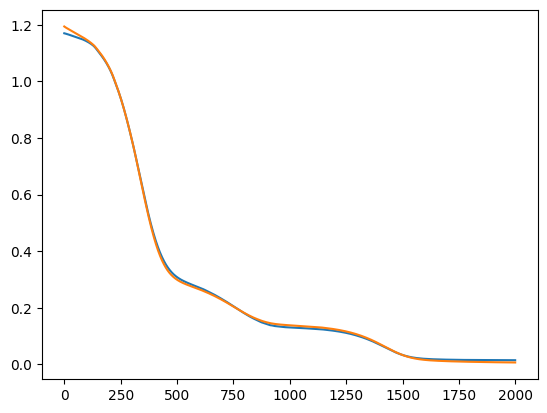

In [137]:
# Initialize the model
model = MLP_model()

# Standardize the data
X_train_norm = standardize(X_train)
y_train_norm = standardize(y_train)
X_test_norm = standardize(X_test)
y_test_norm = standardize(y_test)

# Train the model
train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
